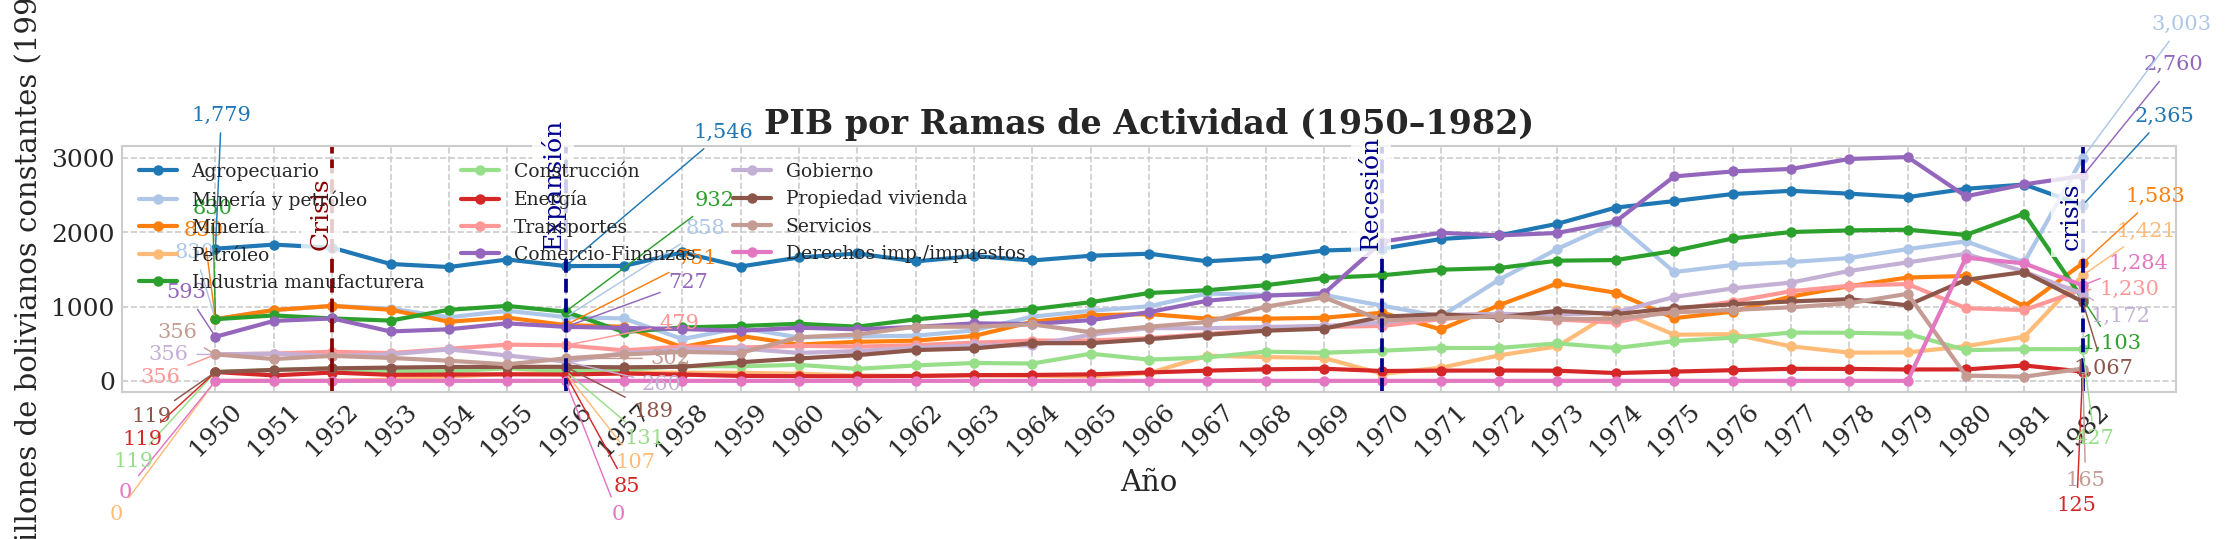

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Configuración general ────────────────────────────────────────
output_dir = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
os.makedirs(output_dir, exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif',
    'font.size':12,
    'axes.titlesize':16,
    'axes.labelsize':14,
    'grid.linestyle':'--',
    'lines.linewidth':2,
    'figure.dpi':150,
    'savefig.bbox':'tight'
})

# ── 2. Carga y conversión (miles → millones) ─────────────────────────
with sqlite3.connect('../../../db/proyectomacro.db') as conn:
    df = pd.read_sql("SELECT * FROM pib_ramas", conn, index_col='año')

# La tabla está en miles de Bs-1990; la convertimos a millones
df = df / 1000

# Filtrar de 1950 a 1982
df = df.loc[1950:1982]

# Definir crisis y post-crisis sobre este rango
crisis = df.loc[1952:1956]
post   = df.loc[1956:1982]

# ── 3. Sectores a graficar ───────────────────────────────────────────
sectores = [
    ("agropecuario",             "Agropecuario"),
    ("minas_canteras_total",     "Minería y petróleo"),
    ("mineria",                  "Minería"),
    ("petroleo",                 "Petróleo"),
    ("industria_manufacturera",  "Industria manufacturera"),
    ("construcciones",           "Construcción"),
    ("energia",                  "Energía"),
    ("transportes",              "Transportes"),
    ("comercio_finanzas",        "Comercio-Finanzas"),
    ("gobierno_general",         "Gobierno"),
    ("propiedad_vivienda",       "Propiedad vivienda"),
    ("servicios",                "Servicios"),
    ("derechos_imp",             "Derechos imp./impuestos")
]

# ── 4. Función de estadísticas para cuadros ────────────────────────
def cuadro_stats(subdf, start, end):
    lines = []
    for col, label in sectores:
        mu = subdf[col].mean()
        dp = (df.loc[end, col] - df.loc[start, col]) / df.loc[start, col] * 100
        lines.append(f"{label}: μ={mu:,.2f}  Δ{end}/{start}={dp:.1f}%")
    return "\n".join(lines)

txt_cr = "Crisis 52-56\n" + cuadro_stats(crisis, 1952, 1956)
txt_po = "Post-crisis 56-82\n" + cuadro_stats(post, 1956, 1982)

# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 9))
cmap = plt.get_cmap('tab20')

for i, (col, label) in enumerate(sectores):
    ax.plot(df.index, df[col],
            label=label,
            color=cmap(i),
            marker='o', markersize=4)

# Líneas divisorias y anotaciones de hitos
for yr, text, color in [(1952, "Crisis", 'darkred'),
                        (1956, "Expansión", 'darkblue'),
                        (1970, "Recesión", 'darkblue'),
                        (1982, "crisis", 'darkblue')]:
    ax.axvline(yr, color=color, linestyle='--', linewidth=1.8)
    ax.text(yr, ax.get_ylim()[1]*0.56, text,
            rotation=90, color=color,
            va='bottom', ha='right',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# ── 6. Anotaciones escalonadas en años clave ───────────────────────
years = [1950, 1956, 1982]
x_shift = {1950: -0.8, 1956: 1.8, 1982: 0.8}
dy_gap  = 300
x_gap   = 0.15

for yr in years:
    # obtener valores y ordenar
    vals = [(df.loc[yr, col], col, idx)
            for idx, (col, _) in enumerate(sectores)]
    vals.sort(key=lambda t: t[0])
    n = len(vals)
    center = (n - 1) / 2

    for rank, (y, col, idx) in enumerate(vals):
        dx = x_shift[yr] + (rank - center) * x_gap
        dy = (rank - center) * dy_gap
        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y),
                    xytext=(yr + dx, y + dy),
                    ha='center', va='center',
                    fontsize=10,
                    color=cmap(idx),
                    arrowprops=dict(arrowstyle='-', color=cmap(idx), linewidth=0.7))

# ── 7. Cuadros de estadísticas ───────────────────────────────────────
# ybox = df.values.max() * 1.9
# ax.text(1948, ybox, txt_cr,
#         fontsize=10, va='top',
#         bbox=dict(facecolor='white', alpha=0.9))
# ax.text(1973, ybox, txt_po,
#         fontsize=10, va='top',
#         bbox=dict(facecolor='white', alpha=0.9))

# ── 8. Formato final ────────────────────────────────────────────────
ax.set_title("PIB por Ramas de Actividad (1950–1982)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos constantes (1990)")
ax.set_xticks(range(1950, 1983))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_ramas_50_82_millones.png"))
plt.show()